<a href="https://colab.research.google.com/github/aimldlnlp/C242-PS395/blob/main/_c242_ps395_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd

daily_logs = pd.read_csv('/content/drive/MyDrive/C242-PS395/data_users.csv')
food_data = pd.read_csv('/content/drive/MyDrive/C242-PS395/food_data.csv')

In [4]:
(daily_logs.head())

,User ID,Date,Dish Name,Sugar
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",29
1,1,2014-09-15,"Uncle Tobys Australia - Vita Brits, 3 Biscuits...",0
2,1,2014-09-15,"Pauls - Smarter White Milk, 600 ml",34
3,1,2014-09-16,"Gatorade - Lemon-Lime (Australia), 600 ml",36
4,1,2014-09-16,"my - McDonalds Espresso Pronto® Flat White, 2 ...",29


In [5]:
(food_data.head())

,food,Sugars
0,cream cheese,0.500
1,neufchatel cheese,2.700
2,requeijao cremoso light catupiry,3.400
3,ricotta cheese,0.091
4,cream cheese low fat,0.900


In [6]:
# Preprocess daily and weekly logs
daily_logs['Date'] = pd.to_datetime(daily_logs['Date'])

In [7]:
#preprocess daily logs
def preprocess_logs_day(daily_logs, daily_sugar_limit=50):
    # Aggregate daily sugar intake
    daily_agg = daily_logs.groupby(['User ID', 'Date']).agg({
        'Dish Name': ', '.join, 'Sugar': 'sum'}).reset_index()
    daily_agg.rename(columns={'User ID': 'user_id', 'Sugar': 'daily_sugar_intake', 'Dish Name': 'input_dish'}, inplace=True)

    # Classify sugar levels
    def classify_sugar(sugar):
        if sugar < 0.8 * daily_sugar_limit:
            return 'Low'
        elif sugar <= daily_sugar_limit:
            return 'Normal'
        else:
            return 'High'
    daily_agg['sugar_level'] = daily_agg['daily_sugar_intake'].apply(classify_sugar)

    return daily_agg



In [8]:
daily_agg = preprocess_logs_day(daily_logs)
(daily_agg.head())

,user_id,Date,input_dish,daily_sugar_intake,sugar_level
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",63,High
1,1,2014-09-16,"Gatorade - Lemon-Lime (Australia), 600 ml, my ...",100,High
2,1,2014-09-17,"my - McDonalds Espresso Pronto® Flat White, 2 ...",105,High
3,1,2014-09-18,"my - McDonalds Espresso Pronto® Flat White, 2 ...",71,High
4,1,2014-09-19,"my - McDonalds Espresso Pronto® Flat White, 2 ...",84,High


In [9]:
#preprocess weekly logs
def preprocess_logs_week(daily_agg, weekly_sugar_limit=350):

    # Aggregate weekly sugar intake
    daily_agg['Week'] = daily_agg['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_agg = daily_agg.groupby(['user_id', 'Week']).agg({
        'input_dish': ', '.join, 'daily_sugar_intake': 'sum'}).reset_index()
    weekly_agg.rename(columns={'daily_sugar_intake': 'weekly_sugar_intake'}, inplace=True)

    # Classify sugar levels
    def classify_sugar(sugar):
        if sugar < 0.8 * weekly_sugar_limit:
            return 'Low'
        elif sugar <= weekly_sugar_limit:
            return 'Normal'
        else:
            return 'High'
    weekly_agg['sugar_level'] = weekly_agg['weekly_sugar_intake'].apply(classify_sugar)

    return weekly_agg

In [10]:
weekly_agg = preprocess_logs_week(daily_agg)
(weekly_agg.head())

,user_id,Week,input_dish,weekly_sugar_intake,sugar_level
0,1,2014-09-15,"my - McDonalds Espresso Pronto® Flat White, 2 ...",667,High
1,1,2014-09-22,"my - McDonalds Espresso Pronto® Flat White, 2 ...",488,High
2,1,2014-09-29,"Gatorade - Lemon-Lime (Australia), 600 ml, Sou...",488,High
3,1,2014-10-06,"my - McDonalds Espresso Pronto® Flat White, 2 ...",586,High
4,1,2014-10-13,"my - McDonalds Espresso Pronto® Flat White, 2 ...",175,Low


In [11]:
X = weekly_agg[['weekly_sugar_intake']]  # features
y = weekly_agg['sugar_level']            # targets

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Low' -> 0, 'Normal' -> 1, 'High' -> 2

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00       286
           2       1.00      1.00      1.00        22

    accuracy                           1.00       345
   macro avg       1.00      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345

Accuracy: 1.0


SYSTEM RECOMMENDATION

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# TF-IDF Vectorizer for the food list
tfidf_vectorizer = TfidfVectorizer()
food_texts = food_data['food'].tolist()  # List of food names
user_foods = weekly_agg['input_dish'].tolist()  # List of food consumed by users
food_tfidf = tfidf_vectorizer.fit_transform(food_texts)
user_food_tfidf = tfidf_vectorizer.transform(user_foods)

# Prepare input features: combine food vectors and sugar intake
user_sugar = weekly_agg['weekly_sugar_intake'].values.reshape(-1, 1)
user_features = np.hstack([user_food_tfidf.toarray(), user_sugar])

# Encode sugar levels to numeric (for supervised learning)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
weekly_agg['sugar_level_encoded'] = label_encoder.fit_transform(weekly_agg['sugar_level'])

# Prepare target (encoded sugar levels)
y = weekly_agg['sugar_level_encoded'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(user_features, y, test_size=0.2, random_state=42)

# Build TensorFlow model for recommendation
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer (food vectors + sugar intake)
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(64, activation='relu'),   # Hidden layer 2
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer (sugar levels)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7741 - loss: 1.3072 - val_accuracy: 0.8580 - val_loss: 0.3509
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8739 - loss: 0.4192 - val_accuracy: 0.8841 - val_loss: 0.2696
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9159 - loss: 0.2317 - val_accuracy: 0.9159 - val_loss: 0.2194
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9150 - loss: 0.2014 - val_accuracy: 0.9159 - val_loss: 0.1967
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9223 - loss: 0.1886 - val_accuracy: 0.9188 - val_loss: 0.1700
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9306 - loss: 0.1579 - val_accuracy: 0.9420 - val_loss: 0.1434
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9314 - loss: 0.1446 - val_accuracy: 0.8928 - val_loss: 0.2138
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9264 - loss: 0.1512 - val_accuracy: 0.

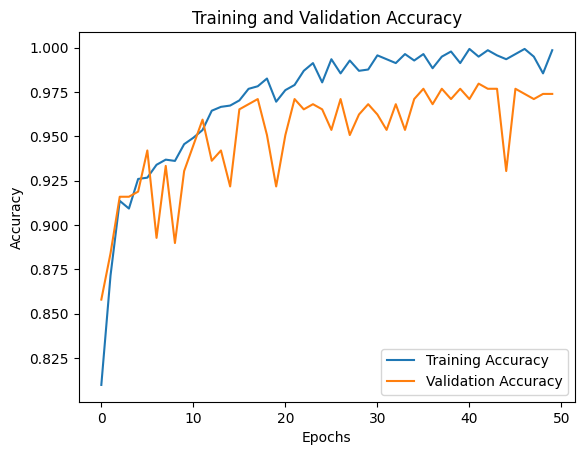

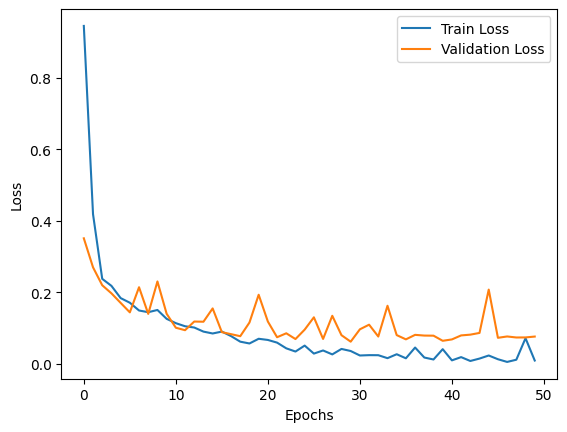

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Make predictions for user recommendations
def recommend_food(user_id, weekly_agg, food_data, model, top_n=5):
    user_info = weekly_agg[weekly_agg['user_id'] == user_id].iloc[0]

    # Get the food list for the user
    user_food_list = user_info['input_dish']
    user_food_tfidf = tfidf_vectorizer.transform([user_food_list]).toarray()

    # Get the user's sugar intake
    user_sugar_intake = user_info['weekly_sugar_intake']

    # Combine the food vectors and sugar intake
    user_input = np.hstack([user_food_tfidf, np.array([[user_sugar_intake]])])

    # Predict sugar level for the user
    user_pred = model.predict(user_input)
    user_pred_class = np.argmax(user_pred, axis=1)[0]

    # Print predicted sugar level for the user
    predicted_sugar_level = label_encoder.inverse_transform([user_pred_class])[0]
    print(f"Predicted sugar level for user {user_id}: {predicted_sugar_level}")

    # Compute cosine similarity between user food list and all food items
    cosine_sim = cosine_similarity(user_food_tfidf, food_tfidf).flatten()

    # Get the top N most similar food items
    recommended_foods = food_data.iloc[np.argsort(cosine_sim)[-top_n:]]

    return recommended_foods[['food', 'Sugars']]

In [15]:
# Example: Recommend foods for user
recommended_foods = recommend_food(11, weekly_agg, food_data, model, top_n=5)
print("Recommended foods based on similarity and sugar level:")
print(recommended_foods)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted sugar level for user 11: Low
Recommended foods based on similarity and sugar level:
               food  Sugars
1459    apple juice    23.9
1424      egg large     0.0
881      crab apple     0.0
1802  milk crackers     1.8
883           apple    18.9


In [16]:
import tensorflow as tf

# Path to save the converted TFLite model
tflite_model_path = 'recommendation_system.tflite'

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Pass the trained model
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model successfully converted and saved at {tflite_model_path}")


Saved artifact at '/tmp/tmphou2zyk1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1376), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136949047227872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136949047228400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136949047225760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136949047224704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136949047225408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136949047226816: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully converted and saved at recommendation_system.tflite


In [17]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='recommendation_system.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Display the input and output details
print("Input Details:", input_details)
print("Output Details:", output_details)

# Prepare test input
import numpy as np
test_input = np.random.rand(1, 1376).astype(np.float32)  # Replace with real test data

# Perform inference
interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()

# Get and print the output
output = interpreter.get_tensor(output_details[0]['index'])
print("Model Output:", output)

Input Details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([   1, 1376], dtype=int32), 'shape_signature': array([  -1, 1376], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Model Output: [[0. 1. 0.]]
